# Regularization
This is a form of regression, that constrains/ shrinks the coefficient estimates towards zero. Regularization is a good technique used to reduce the error and avoid overfitting
## Part 1: Ridge (L2) Regression
### Basic Concept
Ridge regression shrinks the regression coefficients by imposing a penalty on their size. The ridge regression coefficients minimized a penalized residual sum of squares.

Ridge regression solves the following $\ell_2$ penalized linear model 

$$\widehat \beta^{\,\text{ridge}} = \underset{\beta}{\arg\min} \,\, \lVert y - X \beta \rVert^2 + \lambda \lVert \beta \rVert^2$$

The solution can be obtained through 

$$\beta = \big(X^TX + \lambda I\big)^{-1} X^T y $$
### Example
I will use Boston Housing Data from kaggle(https://www.kaggle.com/c/boston-housing/overview). The Boston data frame has 506 rows and 16 columns. I will use "cmedv" as outcome, which means median value of owner-occupied homes in USD 1000's.

In [28]:
import pandas as pd
Housing=pd.read_csv('BostonHousing2.csv')
Y=Housing["cmedv"]
X=Housing.drop("cmedv",1,inplace=False)
Housing[:5]

,lon,lat,cmedv,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,-70.955,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,-70.950,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,-70.936,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,-70.928,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,-70.922,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


The solution of ridge regression is not invariant with respect to the scale of predictors. So first I will scale the data.

In [82]:
from sklearn.preprocessing import StandardScaler
# initialize the Scaler
ss=StandardScaler()
Y_scale=ss.fit_transform(Housing[["cmedv"]])
X_scale=ss.fit_transform(Housing.drop("cmedv",1,inplace=False))
X_scale = pd.DataFrame(X_scale, index=X.index, columns=X.columns)

In [83]:
import numpy as np
import math
n=100 # number of lambda
seq=np.linspace(start=-15, stop=15, num=n)
for i in range(100):
    seq[i]=math.exp(seq[i])

### Tuning parameter $\lambda$
I will use 5-fold cross validation to tune parameter $\lambda$

In [117]:
N=Housing.shape[0] # number of observations
p=Housing.shape[1]
#beta_ridge = np.zeros((n,p)) 
beta_ridge = np.repeat(0,p)
df = np.repeat(0, n) # degree of freedom
CV = list() # Minimized MSE 

for i in range(n):
    MSE=list()
    for j in range(5):
        size=int(N/5)
        if j<4:
            index=np.arange(j*101,(j+1)*101)
        else: 
            index=np.arange(j*101,N)
        x=X_scale.iloc[ index , : ]
        y=Y_scale[index]
        xx=np.dot(np.transpose(x),x)
        xy=np.dot(np.transpose(x),y)
        inv=np.linalg.inv(xx+np.identity(xx.shape[0]) * seq[i])
        beta_ridge= np.dot(inv,xy)
        y_predict=np.dot(X_scale.drop(X_scale.index[index]),beta_ridge)
        MSE.append(np.mean((y_predict.flatten()-np.delete(Y_scale, index))**2))
    CV.append(min(MSE))

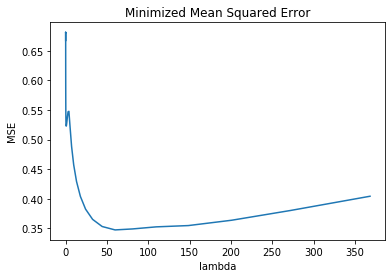

In [127]:
import matplotlib.pyplot as plt
plt.plot(seq[:70], CV[:70])
plt.title("Minimized Mean Squared Error")
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.show()

In [130]:
seq[CV.index(min(CV))]

59.794225389991404

When $\lambda$=60, this model fits best.

### Degree of Freedom  

\begin{aligned}
df(\hat f)&= \frac{1}{\sigma^2}\sum_{i=1}^N Cov(\hat {y_i},y_i) \\
&= \frac{1}{\sigma^2} Var(y_i) Trace(X(X^TX+\lambda I)^{-1}XX^T) \\
&= \sum_{j=1}^p \frac{d_j^2}{d_j^2+\lambda}
\end{aligned}


In [141]:
def RidgeRegression(X, y):
    beta_list = []
    df_list = []
    for i in range(100):
        lam_par = seq[i]
        xtranspose = np.transpose(X)
        xtransx = np.dot(xtranspose, X)
        lamidentity = np.identity(xtransx.shape[0]) * lam_par
        matinv = np.linalg.inv(lamidentity + xtransx)
        xtransy = np.dot(xtranspose, y)
        beta = np.dot(matinv, xtransy)
        _, S, _ = np.linalg.svd(X)
        df = np.sum(np.square(S) / (np.square(S) + lam_par))
        beta_list.append(beta)
        df_list.append(df)
    return beta_list, df_list

def Plots(dfArray, betaArray):
    plt.figure()
    for i in range(0, beta_list[0].shape[0]):
        plt.plot(dfArray, betaArray[:,i])
        plt.scatter(dfArray, betaArray[:,i],s=8)
    plt.xlabel(r"df($\lambda$)")
    plt.ylabel("Coefficients")
    plt.title("$\beta$ Estimate with Degree of Freedom")
    plt.show()

In [134]:
beta_list, df_list = RidgeRegression(X_scale, Y_scale)
betaArray = np.asarray(beta_list)
dfArray = np.asarray(df_list)

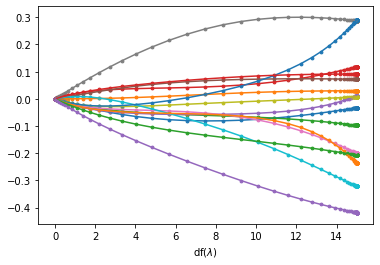

In [142]:
Plots(dfArray, betaArray)

The larger the value of $\lambda$ (the smaller the degree of freedom), the greater the amount of shrinkage, the smaller the coefficients estimate. 

## Part 2: Lasso Regression
LASSO regression solves the following $\ell_1$ penalized linear model 
$$\widehat \beta^{\,\text{Lasso}} = \underset{\beta}{\arg\min} \,\, \lVert y - X \beta \rVert^2 + \lambda \lVert \beta \rVert_1$$